A Deep Learning Toy Model for Image Compression
===

In this project, we will use simple deep learning networks for basic image compression.

You will get familiar with:

* train/test a simple deep learning model (for image compression in this project) with PyTorch library
* hyper-parameter tuning for deep learning model
* collect and analyse the training loss and metrics
* evaluate and visualize the result

## 1. Objectives
1. Train a baseline neural network.
2. Plot the loss-epoch curve.
3. Tune learning rate, the depth of the network, and different layers. Then compare the results in SSIM, PSNR.
4. Visualize some cases.
5. Customize your model (and loss, learning rate, scheduler, etc) for better performance.


## Get GPU ready

Change Runtime Type in the Colab menu to 'GPU'.

## Prepare the data

The data for training/test is at https://drive.google.com/drive/folders/1Ry2G14vY6uWoSG1rilvZOmNLvl3cOSUv?usp=sharing

1. Put this folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (e.g. `'/content/drive/MyDrive/MYDATA'`), and we will use this later.

Hint: you can check the file with either bash command or use the leftmost sidebar in Colab, there's a folder shaped icon.

**Note**: If you store the dataset in Google Drive, accessing the data might be slow due to Google Drive's limitations. Alternatively, you can upload the dataset to Colab's local runtime environment by clicking the '**Files**' button on the left sidebar. This approach can enhance data access speed during the session. However, please be aware that any data uploaded locally will be removed once you restart or exit the Colab session. To avoid data loss, consider reloading the data at the beginning of each session, or consistently use Google Drive mounting to manage your data.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Check the data: When you do `!ls YOUR_DATA_PATH`, you should see `train` and `valid` under the dir.

In [4]:
# cd drive/MyDrive/ELEC5306/
# !cd '/Users/harryk/Documents/usyd/2024sem1/ELEC5306/project2'

## 1.1 Code Template
But feel free to modify if you think it's needed.

Let's first import packages for this project. You are not required to make modifications to this. But if you are using any other packages that's not included, feel free to import anytime.

In [5]:
# ################################################
# import packages

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset

import time

import matplotlib.pyplot as plt


Then we define a Dataset class that could iterate over images under a directory (`root/split`).

You are not required to make modifications to this.

In [6]:
import PIL
from pathlib import Path
import PIL.Image
from torch.utils.data import Dataset

# ################################################
# define our Dataset class

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = PIL.Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


Then let's define a baseline neural network.

In [7]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}


Let's check if this network structure works fine with data flow.

In [8]:
# 1. get some random data
data = torch.zeros((1, 3, 128, 128))
# 2. get a random instance of the model class
model = Network(5, 5)
# 3. forward the data to the model
preds = model(data)
# 4. do compress
compressed = model.compress(data)
# 5. decompress
data_hat = model.decompress(compressed)

If there's no error pops out in the last code cell, then our network is fine.

We can compute the compression ratio of this network

In [9]:
print('compression ratio: compressed/original {}'.format(compressed.numel() / data.numel()))

compression ratio: compressed/original 0.006510416666666667


The compression ratio of this random network is suprising, but we don't expect any good performance as the model is too small.

Usually the larger the model, the better the performance given sufficient training data and iterations.

Let's move on to the loss, average meter, and optimizer.

A good thing about this task is we don't need extra label but the input image.

The loss is simply compared between the decoded image and the original one.

In [10]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [11]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [13]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

After we almost got everything we need, we define a `train_one_epoch` function for training the model for one epoch.

In [14]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


Likewise we further define a `test_epoch` function for getting the error on a valid set.

This part of data is not used in the training process, and will only be used to check the performance and give us implications of the performance of the model on unseen data.

This function returns the average loss on the valid split data.

In [15]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f}\n"
    )

    return loss.avg

Finally we define a main function, and complete the whole training/testing process.

At the start of this main function, we define some arguments that's useful for training.

Define some arguments useful for training/validation.

In [16]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = 'C:\somethings\Kevin'       # path to the root of the dataset Modify this if you change the path
checkpoint = ''                                   # load pretrained model
epochs = 10                                       # total training epochs
num_workers = 0                                  # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4
batch_size = 16
test_batch_size = 16
N = 128
M = 192

In [17]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

#0423log: device is False cause "torch.cuda.is_available()" is False
#log: install the fit cuda, cudnn. 

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda")
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda")
)

net = Network(N, M)
net = net.to(device)
print("training on", device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
start = time.time()
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
print(f"finished training in {round(time.time()-start)} seconds")


training on cuda
Learning rate: 0.0001


Train epoch 0: [0/250 (0%)]	Loss: 3247.637 |	MSE loss: 12.736
Train epoch 0: [160/250 (62%)]	Loss: 191.252 |	MSE loss: 0.750
Test epoch 0: Average losses:	Loss: 98.126 |	MSE loss: 0.385

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 99.872 |	MSE loss: 0.392
Train epoch 1: [160/250 (62%)]	Loss: 45.795 |	MSE loss: 0.180
Test epoch 1: Average losses:	Loss: 50.614 |	MSE loss: 0.198

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 49.660 |	MSE loss: 0.195
Train epoch 2: [160/250 (62%)]	Loss: 35.842 |	MSE loss: 0.141
Test epoch 2: Average losses:	Loss: 36.023 |	MSE loss: 0.141

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 22.963 |	MSE loss: 0.090
Train epoch 3: [160/250 (62%)]	Loss: 13.062 |	MSE loss: 0.051
Test epoch 3: Average losses:	Loss: 24.047 |	MSE loss: 0.094

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 20.189 |	MSE loss: 0.079
Train epoch 4: [160/250 (62%)]	Loss: 12.992 |	MSE loss: 0.051
Test epoch 4: Average losses:	Loss: 16.838 |	MSE loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'compressed-decoded')

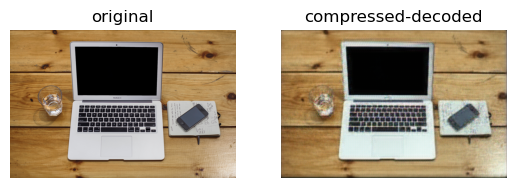

In [18]:
# visualization
import matplotlib.pyplot as plt

dataset = 'C:\somethings\Kevin' # Modify this if you change the path
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[1].unsqueeze(0).to(device)
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()

fig, axes = plt.subplots(1,2)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

## 1.2 PSNR as AverageMeter for testing


A scratch example of PSNR, no guarantee of working.

Free to grab online.




In [19]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))


A scratch example of SSIM, details are at https://github.com/VainF/pytorch-msssim

In [20]:
# !pip install pytorch-msssim

In [21]:
import torch
from pytorch_msssim import ssim

# X: (N,3,H,W) a batch of non-negative RGB images (0~1)
# Y: (N,3,H,W)

X = torch.randn((2, 3, 10, 10))
Y = torch.randn((2, 3, 10, 10))

X = X * 255
Y = Y * 255

# calculate ssim & ms-ssim for each image
ssim_val = ssim(X, Y, data_range=255, size_average=False) # return (N,)
print(ssim_val)

tensor([0.0010, 0.0571])


c:\ProgramData\anaconda3\Lib\site-packages\pytorch_msssim\ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\pytorch_msssim\ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  warnings.warn(



Your code here:

In [22]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    ssim_avg = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            psnr.update(PSNR(d_out, d))
            ssim_avg.update(ssim(d * 255, d_out * 255, data_range=255, size_average=True))

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR: {psnr.avg:.3f} |"
        f"\tSSIM: {ssim_avg.avg:.3f}\n"
    )

    return loss.avg

# do the test on valid split
test_epoch(10, test_dataloader, net, criterion)


Test epoch 10: Average losses:	Loss: 6.746 |	MSE loss: 0.026 |	PSNR: 15.776 |	SSIM: 0.155



tensor(6.7455, device='cuda:0')

## 1.3 Loss-Epoch curve


A naive example, no guarantee of working.

In [23]:
# import matplotlib.pyplot as plt

loss_epoch = list()
start = time.time()
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    loss_epoch.append(loss)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)


print(f"finished training in {round(time.time()-start)} seconds")


Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 6.965 |	MSE loss: 0.027
Train epoch 0: [160/250 (62%)]	Loss: 3.013 |	MSE loss: 0.012
Test epoch 0: Average losses:	Loss: 5.554 |	MSE loss: 0.022 |	PSNR: 16.620 |	SSIM: 0.189

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 6.727 |	MSE loss: 0.026
Train epoch 1: [160/250 (62%)]	Loss: 3.017 |	MSE loss: 0.012
Test epoch 1: Average losses:	Loss: 4.752 |	MSE loss: 0.019 |	PSNR: 17.298 |	SSIM: 0.220

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 5.800 |	MSE loss: 0.023
Train epoch 2: [160/250 (62%)]	Loss: 6.409 |	MSE loss: 0.025
Test epoch 2: Average losses:	Loss: 8.207 |	MSE loss: 0.032 |	PSNR: 14.926 |	SSIM: 0.172

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 7.309 |	MSE loss: 0.029
Train epoch 3: [160/250 (62%)]	Loss: 3.951 |	MSE loss: 0.015
Test epoch 3: Average losses:	Loss: 4.227 |	MSE loss: 0.017 |	PSNR: 17.805 |	SSIM: 0.230

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 3.296 |	MSE loss: 0.

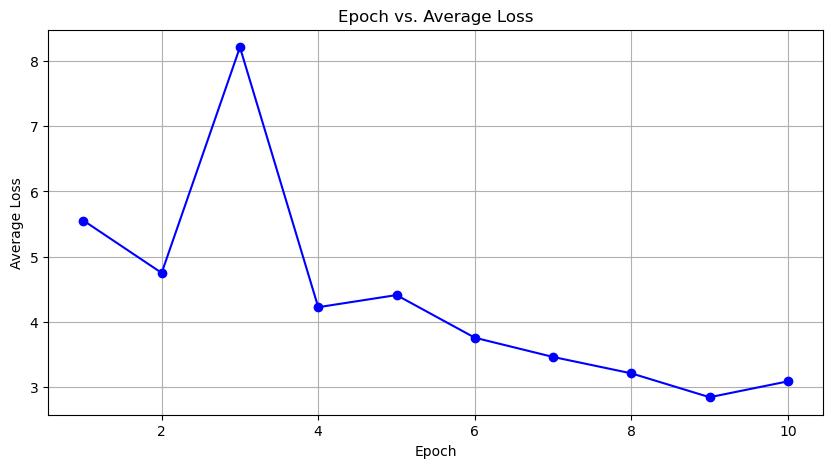

In [24]:
def plotloss(epochs,loss_epoch):

    xs = range(1, epochs + 1)
    ys = loss_epoch
    y = []
    for i in ys:
        y.append(i.cpu().detach().numpy())


    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(xs, y, marker='o', linestyle='-', color='b')
    plt.title('Epoch vs. Average Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plotloss(10,loss_epoch)


Your code here:

## 1.4 Tune hyper parameters and complete corresponding analysis

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 76.677 |	MSE loss: 0.301 |	PSNR: 5.220 |	SSIM: 0.011

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 40.640 |	MSE loss: 0.159 |	PSNR: 7.977 |	SSIM: 0.033

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 13.886 |	MSE loss: 0.054 |	PSNR: 12.640 |	SSIM: 0.088

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 9.062 |	MSE loss: 0.036 |	PSNR: 14.494 |	SSIM: 0.106

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 6.048 |	MSE loss: 0.024 |	PSNR: 16.251 |	SSIM: 0.171

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 11.927 |	MSE loss: 0.047 |	PSNR: 13.302 |	SSIM: 0.179

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 8.590 |	MSE loss: 0.034 |	PSNR: 14.728 |	SSI

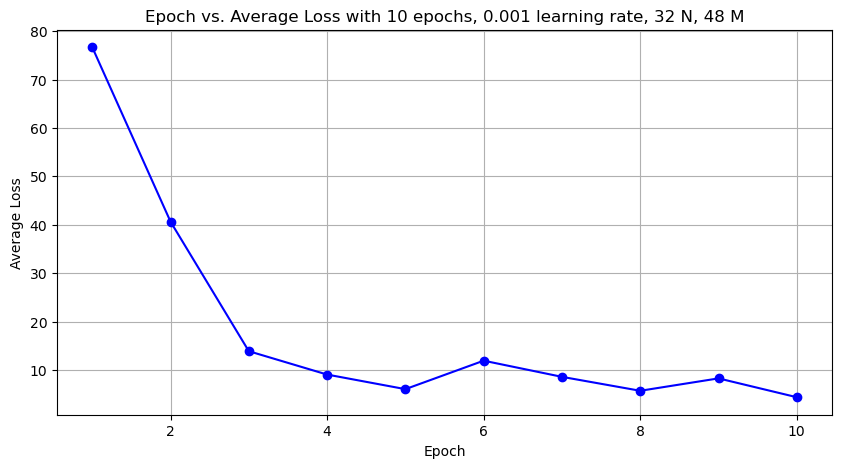

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 24.609 |	MSE loss: 0.097 |	PSNR: 10.155 |	SSIM: 0.032

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 12.167 |	MSE loss: 0.048 |	PSNR: 13.214 |	SSIM: 0.090

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 13.358 |	MSE loss: 0.052 |	PSNR: 12.810 |	SSIM: 0.122

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 7.390 |	MSE loss: 0.029 |	PSNR: 15.382 |	SSIM: 0.177

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 8.969 |	MSE loss: 0.035 |	PSNR: 14.546 |	SSIM: 0.211

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 7.873 |	MSE loss: 0.031 |	PSNR: 15.125 |	SSIM: 0.206

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 5.139 |	MSE loss: 0.020 |	PSNR: 16.963 |	SS

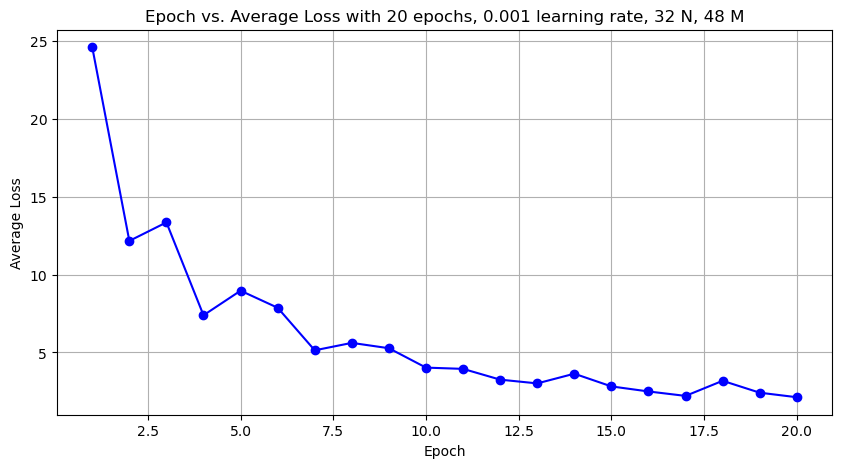

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 23.546 |	MSE loss: 0.092 |	PSNR: 10.347 |	SSIM: 0.038

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 14.802 |	MSE loss: 0.058 |	PSNR: 12.364 |	SSIM: 0.072

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 15.983 |	MSE loss: 0.063 |	PSNR: 12.029 |	SSIM: 0.082

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 27.514 |	MSE loss: 0.108 |	PSNR: 9.705 |	SSIM: 0.089

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 13.144 |	MSE loss: 0.052 |	PSNR: 12.890 |	SSIM: 0.092

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 8.594 |	MSE loss: 0.034 |	PSNR: 14.726 |	SSIM: 0.180

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 9.135 |	MSE loss: 0.036 |	PSNR: 14.458 |	S

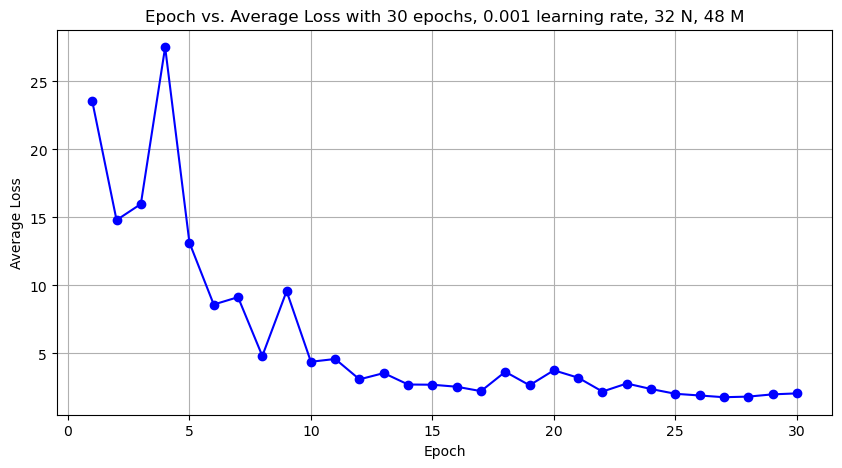

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 100.684 |	MSE loss: 0.395 |	PSNR: 4.041 |	SSIM: 0.004

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 49.381 |	MSE loss: 0.194 |	PSNR: 7.132 |	SSIM: 0.014

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 26.144 |	MSE loss: 0.103 |	PSNR: 9.893 |	SSIM: 0.034

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 18.438 |	MSE loss: 0.072 |	PSNR: 11.409 |	SSIM: 0.067

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 14.799 |	MSE loss: 0.058 |	PSNR: 12.364 |	SSIM: 0.082

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 12.951 |	MSE loss: 0.051 |	PSNR: 12.943 |	SSIM: 0.105

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 11.999 |	MSE loss: 0.047 |	PSNR: 13

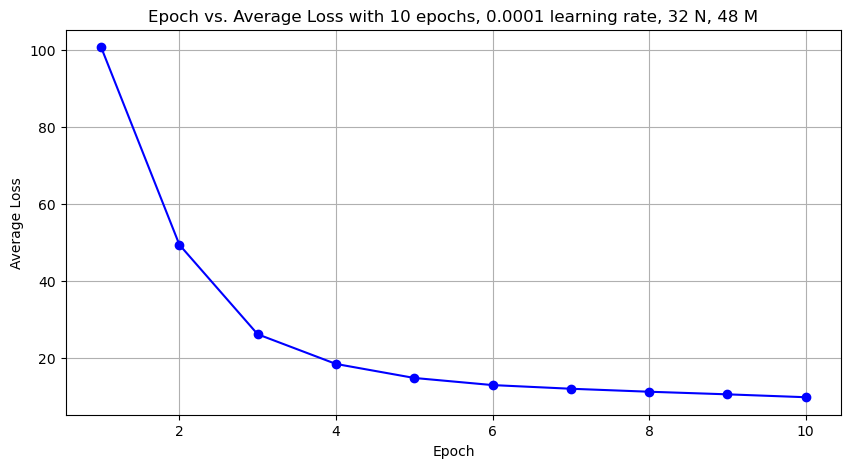

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 96.965 |	MSE loss: 0.380 |	PSNR: 4.204 |	SSIM: 0.005

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 48.281 |	MSE loss: 0.189 |	PSNR: 7.229 |	SSIM: 0.014

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 26.640 |	MSE loss: 0.104 |	PSNR: 9.810 |	SSIM: 0.034

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 18.539 |	MSE loss: 0.073 |	PSNR: 11.385 |	SSIM: 0.063

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 14.485 |	MSE loss: 0.057 |	PSNR: 12.457 |	SSIM: 0.089

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 12.258 |	MSE loss: 0.048 |	PSNR: 13.182 |	SSIM: 0.111

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 11.013 |	MSE loss: 0.043 |	PSNR: 13.

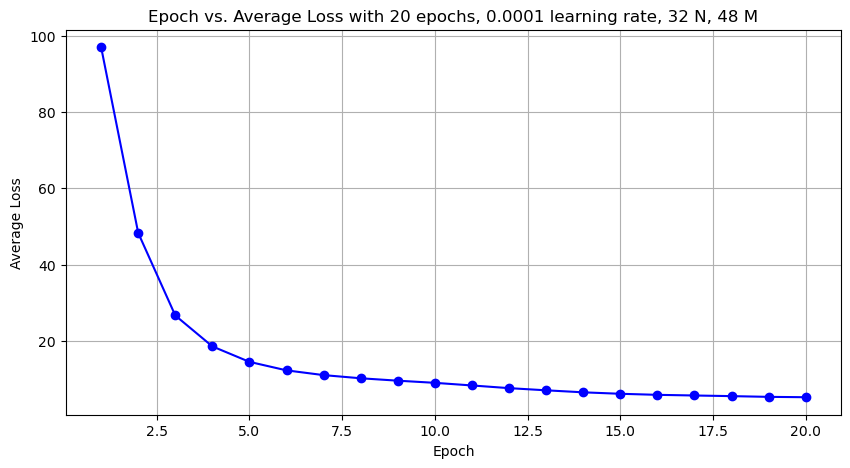

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 120.595 |	MSE loss: 0.473 |	PSNR: 3.256 |	SSIM: 0.002

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 74.005 |	MSE loss: 0.290 |	PSNR: 5.375 |	SSIM: 0.009

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 39.531 |	MSE loss: 0.155 |	PSNR: 8.096 |	SSIM: 0.020

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 22.212 |	MSE loss: 0.087 |	PSNR: 10.600 |	SSIM: 0.039

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 17.334 |	MSE loss: 0.068 |	PSNR: 11.677 |	SSIM: 0.064

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 15.769 |	MSE loss: 0.062 |	PSNR: 12.088 |	SSIM: 0.080

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 14.701 |	MSE loss: 0.058 |	PSNR: 12

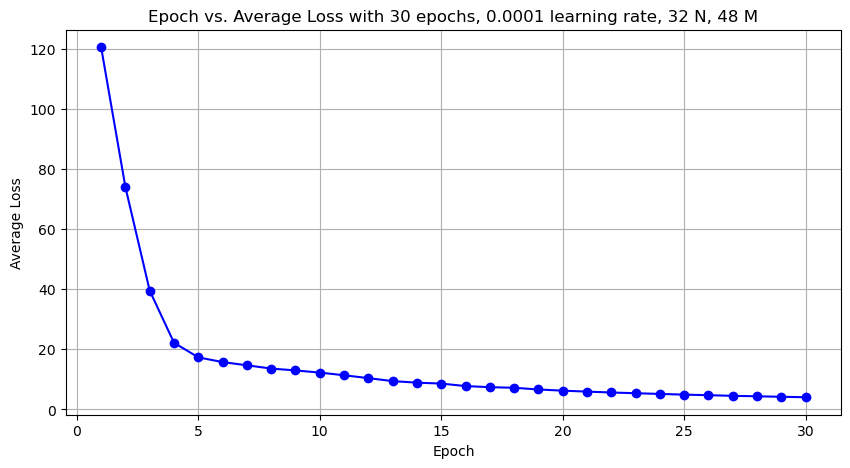

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 384.461 |	MSE loss: 1.508 |	PSNR: -1.783 |	SSIM: 0.000

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 234.265 |	MSE loss: 0.919 |	PSNR: 0.369 |	SSIM: 0.000

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 164.982 |	MSE loss: 0.647 |	PSNR: 1.892 |	SSIM: 0.000

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 133.728 |	MSE loss: 0.524 |	PSNR: 2.805 |	SSIM: 0.001

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 117.562 |	MSE loss: 0.461 |	PSNR: 3.366 |	SSIM: 0.001

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 107.576 |	MSE loss: 0.422 |	PSNR: 3.752 |	SSIM: 0.002

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 99.679 |	MSE loss: 0.391 |	PSNR: 4.083 

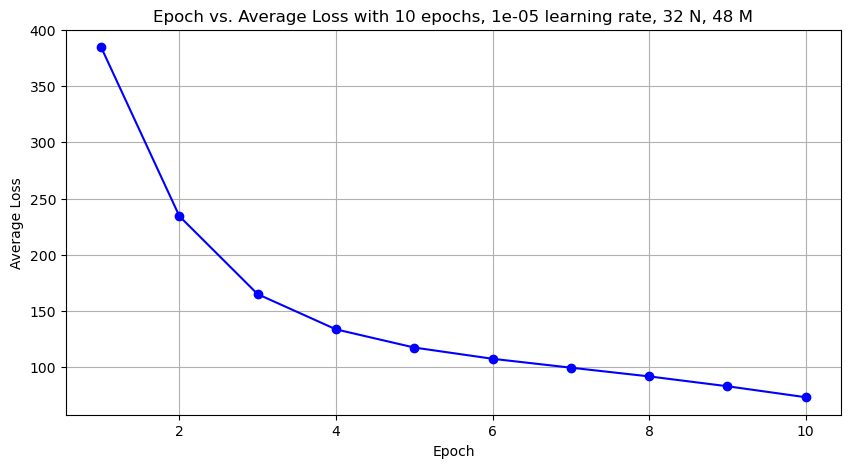

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 362.663 |	MSE loss: 1.422 |	PSNR: -1.511 |	SSIM: -0.000

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 235.193 |	MSE loss: 0.922 |	PSNR: 0.366 |	SSIM: -0.000

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 172.872 |	MSE loss: 0.678 |	PSNR: 1.699 |	SSIM: 0.000

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 142.393 |	MSE loss: 0.558 |	PSNR: 2.538 |	SSIM: 0.000

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 125.356 |	MSE loss: 0.492 |	PSNR: 3.090 |	SSIM: 0.001

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 114.277 |	MSE loss: 0.448 |	PSNR: 3.491 |	SSIM: 0.002

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 106.285 |	MSE loss: 0.417 |	PSNR: 3.8

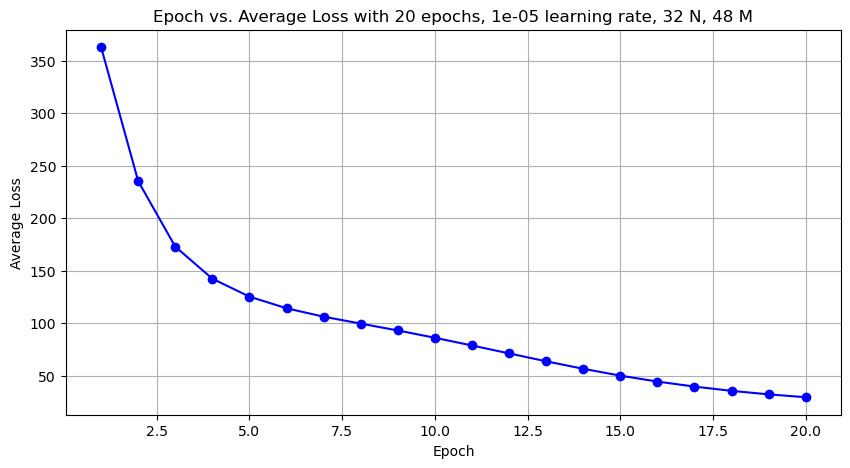

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 0: Average losses:	Loss: 462.788 |	MSE loss: 1.815 |	PSNR: -2.579 |	SSIM: -0.000

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 1: Average losses:	Loss: 304.486 |	MSE loss: 1.194 |	PSNR: -0.762 |	SSIM: -0.000

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 2: Average losses:	Loss: 217.926 |	MSE loss: 0.855 |	PSNR: 0.690 |	SSIM: -0.000

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 3: Average losses:	Loss: 170.348 |	MSE loss: 0.668 |	PSNR: 1.759 |	SSIM: 0.000

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 4: Average losses:	Loss: 143.257 |	MSE loss: 0.562 |	PSNR: 2.511 |	SSIM: 0.000

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 5: Average losses:	Loss: 127.584 |	MSE loss: 0.500 |	PSNR: 3.013 |	SSIM: 0.001

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 6: Average losses:	Loss: 117.734 |	MSE loss: 0.462 |	PSNR: 3

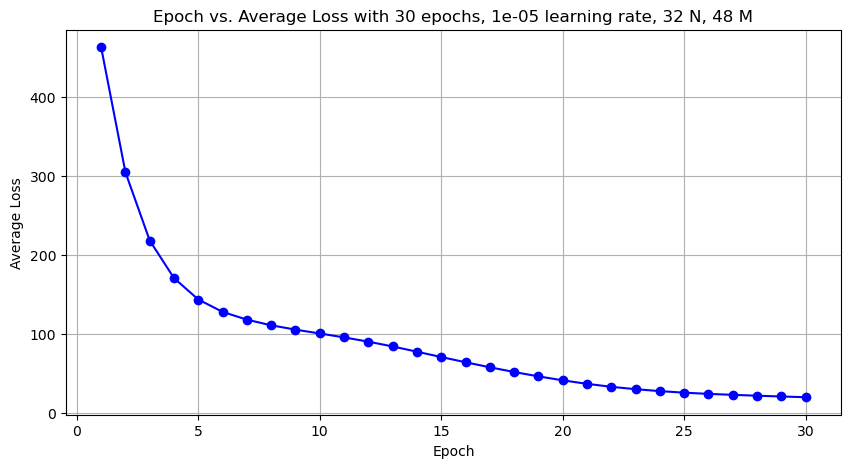

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 55.908 |	MSE loss: 0.219 |	PSNR: 6.609 |	SSIM: 0.015

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 68.865 |	MSE loss: 0.270 |	PSNR: 5.691 |	SSIM: 0.018

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 13.729 |	MSE loss: 0.054 |	PSNR: 12.689 |	SSIM: 0.065

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 13.582 |	MSE loss: 0.053 |	PSNR: 12.736 |	SSIM: 0.073

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 8.881 |	MSE loss: 0.035 |	PSNR: 14.581 |	SSIM: 0.117

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 6.041 |	MSE loss: 0.024 |	PSNR: 16.256 |	SSIM: 0.197

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 11.763 |	MSE loss: 0.046 |	PSNR: 13.374 |	SS

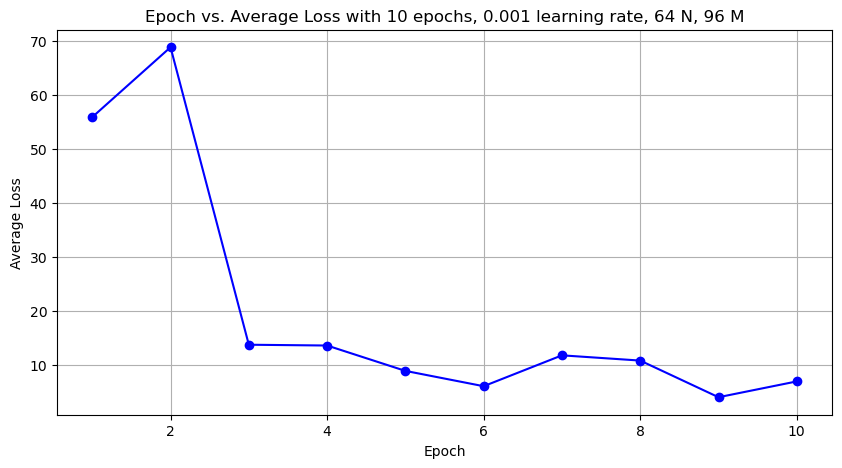

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 54.302 |	MSE loss: 0.213 |	PSNR: 6.722 |	SSIM: 0.011

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 137.958 |	MSE loss: 0.541 |	PSNR: 2.670 |	SSIM: 0.004

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 15.779 |	MSE loss: 0.062 |	PSNR: 12.085 |	SSIM: 0.055

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 34.724 |	MSE loss: 0.136 |	PSNR: 8.668 |	SSIM: 0.043

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 15.336 |	MSE loss: 0.060 |	PSNR: 12.210 |	SSIM: 0.096

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 7.791 |	MSE loss: 0.031 |	PSNR: 15.156 |	SSIM: 0.153

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 8.320 |	MSE loss: 0.033 |	PSNR: 14.867 |	SS

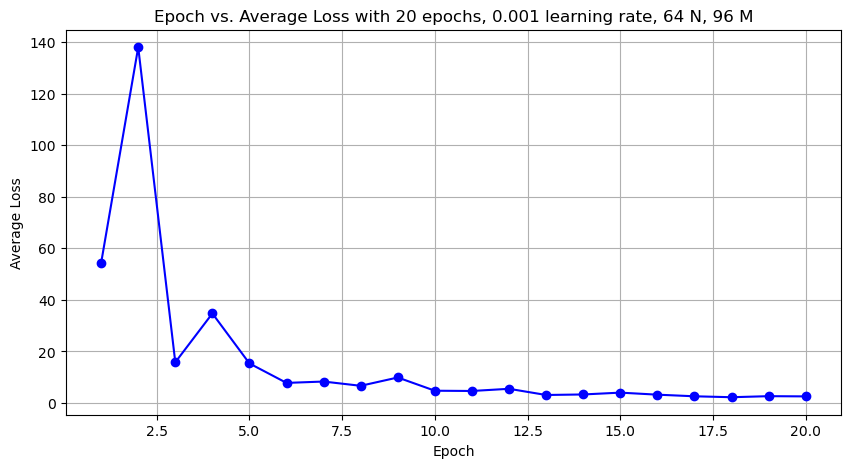

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 51.322 |	MSE loss: 0.201 |	PSNR: 6.963 |	SSIM: 0.014

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 39.034 |	MSE loss: 0.153 |	PSNR: 8.154 |	SSIM: 0.040

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 20.220 |	MSE loss: 0.079 |	PSNR: 11.008 |	SSIM: 0.090

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 8.988 |	MSE loss: 0.035 |	PSNR: 14.533 |	SSIM: 0.130

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 10.075 |	MSE loss: 0.040 |	PSNR: 14.046 |	SSIM: 0.143

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 6.893 |	MSE loss: 0.027 |	PSNR: 15.700 |	SSIM: 0.167

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 5.781 |	MSE loss: 0.023 |	PSNR: 16.451 |	SSI

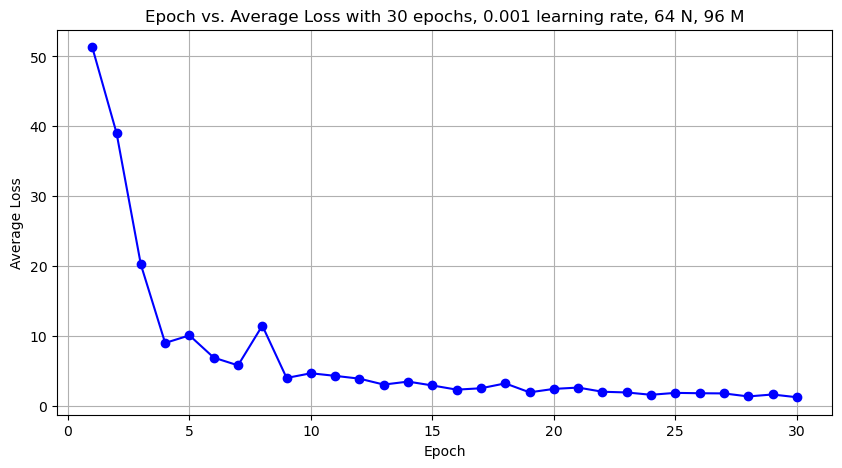

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 100.728 |	MSE loss: 0.395 |	PSNR: 4.038 |	SSIM: 0.006

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 38.432 |	MSE loss: 0.151 |	PSNR: 8.219 |	SSIM: 0.025

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 26.485 |	MSE loss: 0.104 |	PSNR: 9.836 |	SSIM: 0.044

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 22.148 |	MSE loss: 0.087 |	PSNR: 10.612 |	SSIM: 0.059

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 19.495 |	MSE loss: 0.076 |	PSNR: 11.167 |	SSIM: 0.070

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 16.679 |	MSE loss: 0.065 |	PSNR: 11.844 |	SSIM: 0.079

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 14.571 |	MSE loss: 0.057 |	PSNR: 12

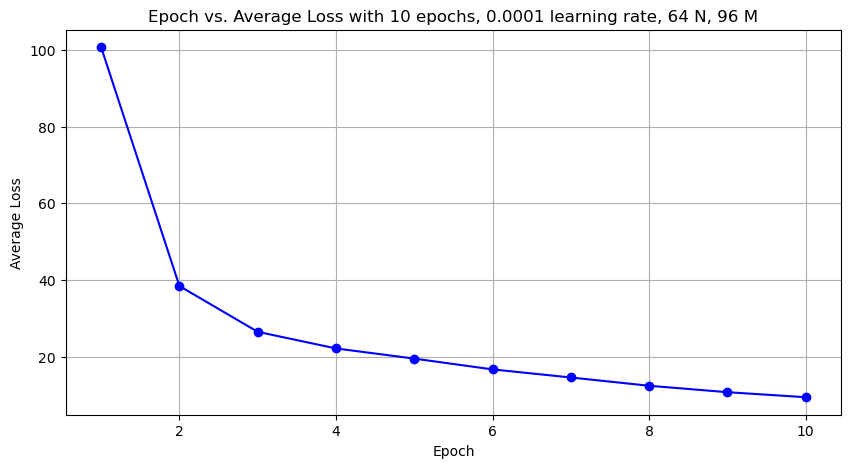

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 84.728 |	MSE loss: 0.332 |	PSNR: 4.788 |	SSIM: 0.008

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 34.919 |	MSE loss: 0.137 |	PSNR: 8.635 |	SSIM: 0.032

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 25.102 |	MSE loss: 0.098 |	PSNR: 10.069 |	SSIM: 0.044

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 20.856 |	MSE loss: 0.082 |	PSNR: 10.874 |	SSIM: 0.065

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 18.435 |	MSE loss: 0.072 |	PSNR: 11.411 |	SSIM: 0.076

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 15.444 |	MSE loss: 0.061 |	PSNR: 12.180 |	SSIM: 0.088

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 12.941 |	MSE loss: 0.051 |	PSNR: 12

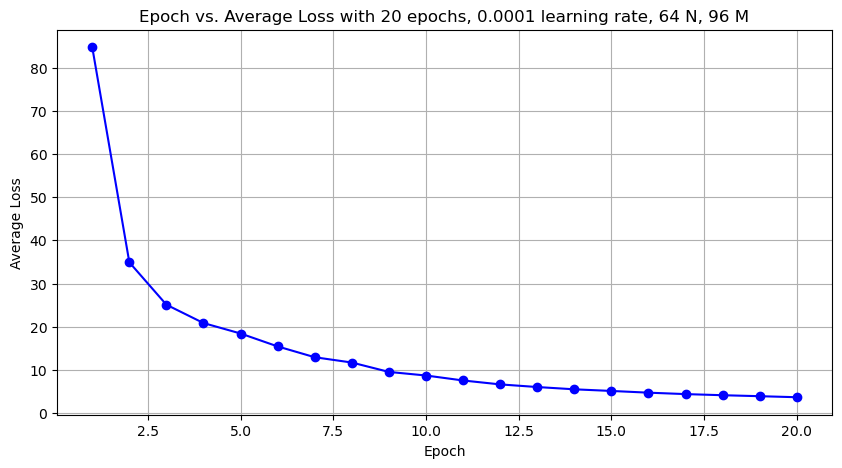

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 104.094 |	MSE loss: 0.408 |	PSNR: 3.894 |	SSIM: 0.006

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 42.666 |	MSE loss: 0.167 |	PSNR: 7.765 |	SSIM: 0.023

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 31.231 |	MSE loss: 0.122 |	PSNR: 9.120 |	SSIM: 0.039

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 25.049 |	MSE loss: 0.098 |	PSNR: 10.078 |	SSIM: 0.052

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 20.669 |	MSE loss: 0.081 |	PSNR: 10.913 |	SSIM: 0.065

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 16.596 |	MSE loss: 0.065 |	PSNR: 11.867 |	SSIM: 0.072

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 13.019 |	MSE loss: 0.051 |	PSNR: 12

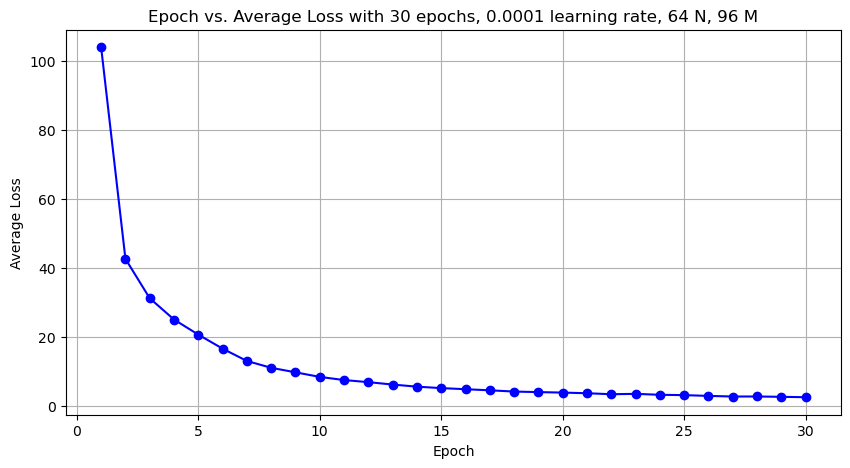

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 561.634 |	MSE loss: 2.202 |	PSNR: -3.424 |	SSIM: 0.000

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 273.249 |	MSE loss: 1.072 |	PSNR: -0.297 |	SSIM: 0.001

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 189.336 |	MSE loss: 0.742 |	PSNR: 1.298 |	SSIM: 0.001

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 150.811 |	MSE loss: 0.591 |	PSNR: 2.285 |	SSIM: 0.002

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 123.402 |	MSE loss: 0.484 |	PSNR: 3.155 |	SSIM: 0.004

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 99.297 |	MSE loss: 0.389 |	PSNR: 4.098 |	SSIM: 0.006

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 79.540 |	MSE loss: 0.312 |	PSNR: 5.061 

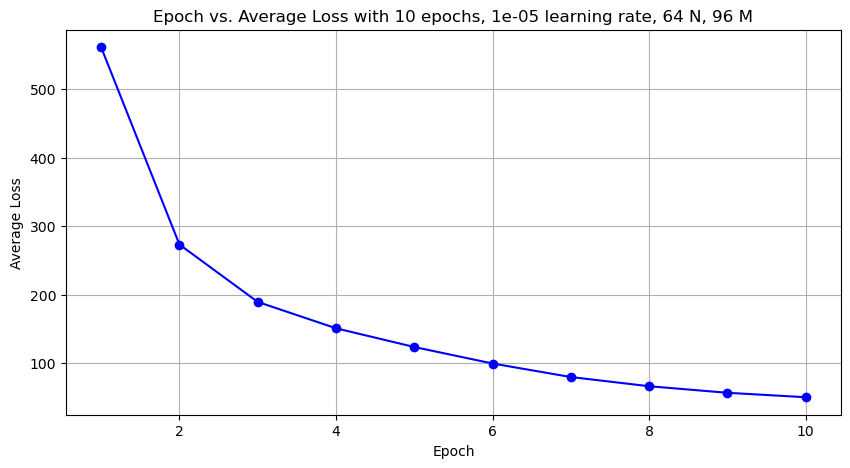

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 568.939 |	MSE loss: 2.231 |	PSNR: -3.481 |	SSIM: 0.000

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 297.595 |	MSE loss: 1.167 |	PSNR: -0.664 |	SSIM: 0.001

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 198.381 |	MSE loss: 0.778 |	PSNR: 1.097 |	SSIM: 0.002

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 148.369 |	MSE loss: 0.582 |	PSNR: 2.357 |	SSIM: 0.003

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 114.741 |	MSE loss: 0.450 |	PSNR: 3.473 |	SSIM: 0.005

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 89.887 |	MSE loss: 0.352 |	PSNR: 4.532 |	SSIM: 0.007

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 72.124 |	MSE loss: 0.283 |	PSNR: 5.487 

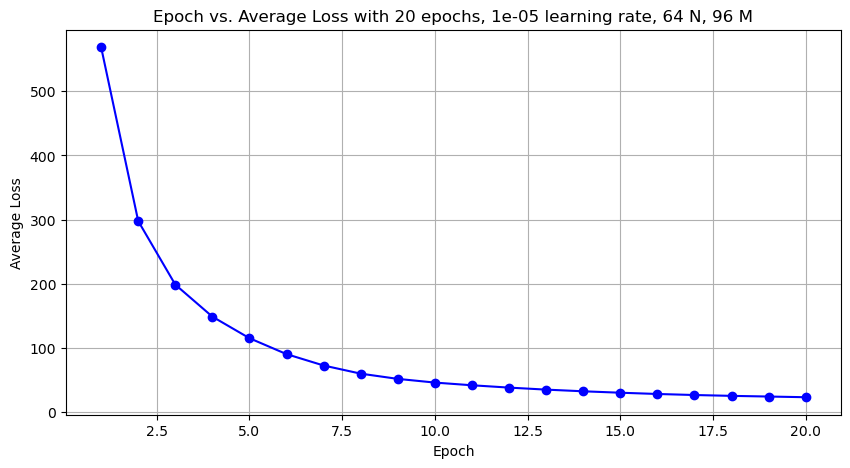

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 0: Average losses:	Loss: 550.348 |	MSE loss: 2.158 |	PSNR: -3.339 |	SSIM: 0.000

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 1: Average losses:	Loss: 282.153 |	MSE loss: 1.106 |	PSNR: -0.435 |	SSIM: 0.001

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 2: Average losses:	Loss: 189.682 |	MSE loss: 0.744 |	PSNR: 1.290 |	SSIM: 0.001

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 3: Average losses:	Loss: 145.097 |	MSE loss: 0.569 |	PSNR: 2.454 |	SSIM: 0.003

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 4: Average losses:	Loss: 113.551 |	MSE loss: 0.445 |	PSNR: 3.519 |	SSIM: 0.005

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 5: Average losses:	Loss: 89.512 |	MSE loss: 0.351 |	PSNR: 4.551 |	SSIM: 0.007

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 6: Average losses:	Loss: 72.182 |	MSE loss: 0.283 |	PSNR: 5.484 

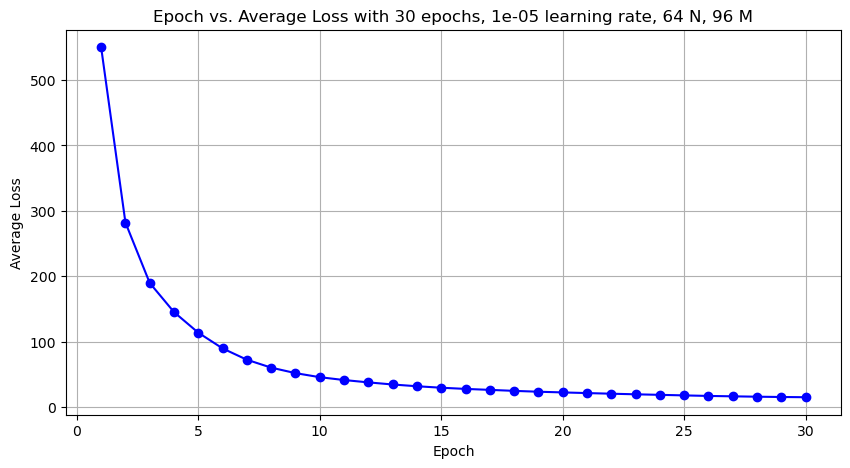

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 5248.267 |	MSE loss: 20.581 |	PSNR: -13.119 |	SSIM: 0.000

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 212.464 |	MSE loss: 0.833 |	PSNR: 0.795 |	SSIM: 0.002

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 36.591 |	MSE loss: 0.143 |	PSNR: 8.433 |	SSIM: 0.018

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 26.485 |	MSE loss: 0.104 |	PSNR: 9.836 |	SSIM: 0.032

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 39.618 |	MSE loss: 0.155 |	PSNR: 8.090 |	SSIM: 0.031

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 106.453 |	MSE loss: 0.417 |	PSNR: 3.808 |	SSIM: 0.013

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 34.295 |	MSE loss: 0.134 

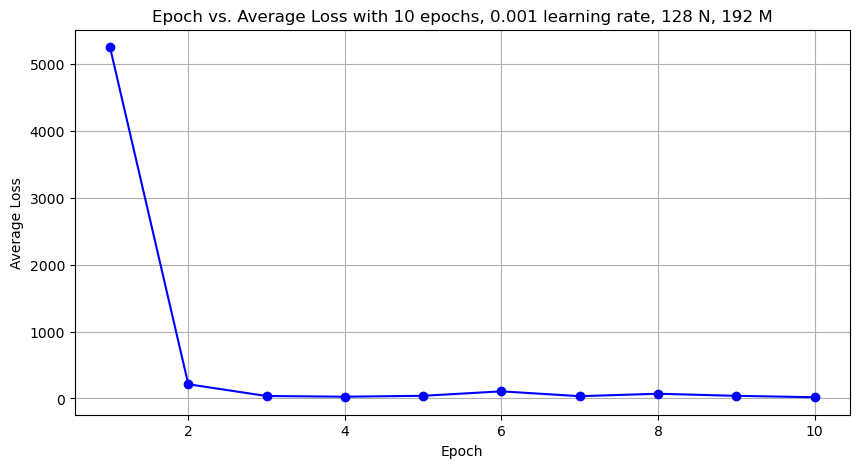

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 1259.583 |	MSE loss: 4.940 |	PSNR: -6.925 |	SSIM: 0.000

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 69.125 |	MSE loss: 0.271 |	PSNR: 5.670 |	SSIM: 0.008

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 31.247 |	MSE loss: 0.123 |	PSNR: 9.119 |	SSIM: 0.033

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 296.531 |	MSE loss: 1.163 |	PSNR: -0.623 |	SSIM: 0.013

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 68.924 |	MSE loss: 0.270 |	PSNR: 5.724 |	SSIM: 0.030

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 21.653 |	MSE loss: 0.085 |	PSNR: 10.763 |	SSIM: 0.045

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 16.825 |	MSE loss: 0.066 |

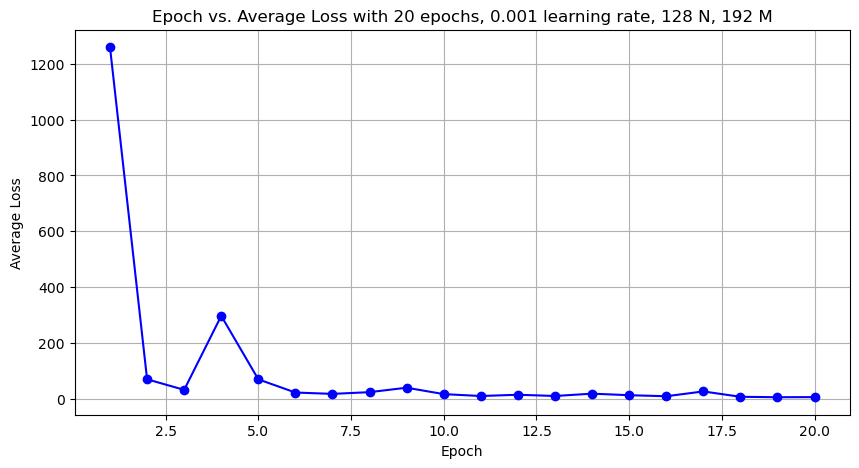

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 1761.309 |	MSE loss: 6.907 |	PSNR: -8.390 |	SSIM: 0.000

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 225.036 |	MSE loss: 0.882 |	PSNR: 0.604 |	SSIM: 0.003

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 39.720 |	MSE loss: 0.156 |	PSNR: 8.075 |	SSIM: 0.019

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 26.205 |	MSE loss: 0.103 |	PSNR: 9.913 |	SSIM: 0.049

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 18.592 |	MSE loss: 0.073 |	PSNR: 11.381 |	SSIM: 0.046

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 19.207 |	MSE loss: 0.075 |	PSNR: 11.238 |	SSIM: 0.054

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 19.818 |	MSE loss: 0.078 |

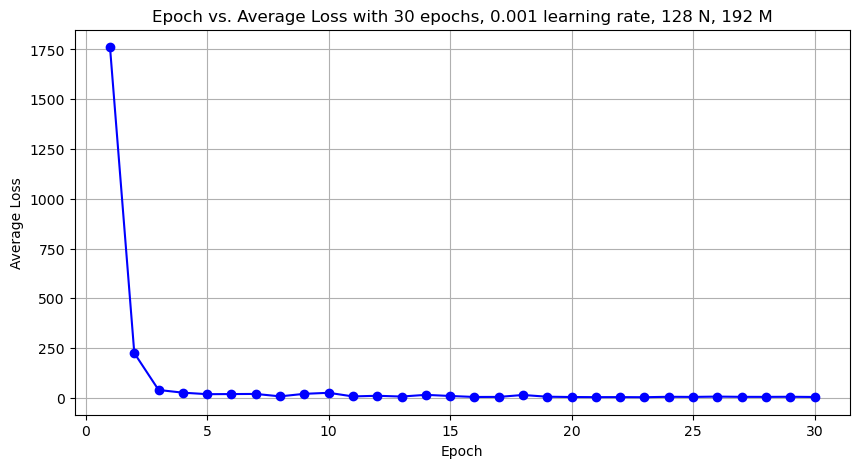

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 86.897 |	MSE loss: 0.341 |	PSNR: 4.676 |	SSIM: 0.009

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 48.869 |	MSE loss: 0.192 |	PSNR: 7.176 |	SSIM: 0.023

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 35.156 |	MSE loss: 0.138 |	PSNR: 8.607 |	SSIM: 0.035

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 24.247 |	MSE loss: 0.095 |	PSNR: 10.221 |	SSIM: 0.050

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 17.360 |	MSE loss: 0.068 |	PSNR: 11.674 |	SSIM: 0.063

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 13.004 |	MSE loss: 0.051 |	PSNR: 12.927 |	SSIM: 0.080

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 11.067 |	MSE loss: 0.0

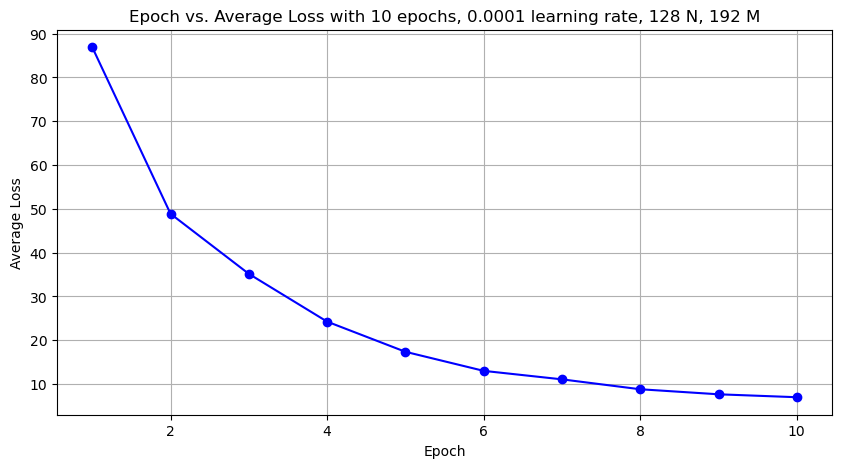

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 114.933 |	MSE loss: 0.451 |	PSNR: 3.463 |	SSIM: 0.006

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 63.883 |	MSE loss: 0.251 |	PSNR: 6.012 |	SSIM: 0.013

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 40.146 |	MSE loss: 0.157 |	PSNR: 8.029 |	SSIM: 0.027

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 28.248 |	MSE loss: 0.111 |	PSNR: 9.556 |	SSIM: 0.040

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 20.384 |	MSE loss: 0.080 |	PSNR: 10.974 |	SSIM: 0.053

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 14.345 |	MSE loss: 0.056 |	PSNR: 12.500 |	SSIM: 0.075

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 11.885 |	MSE loss: 0.0

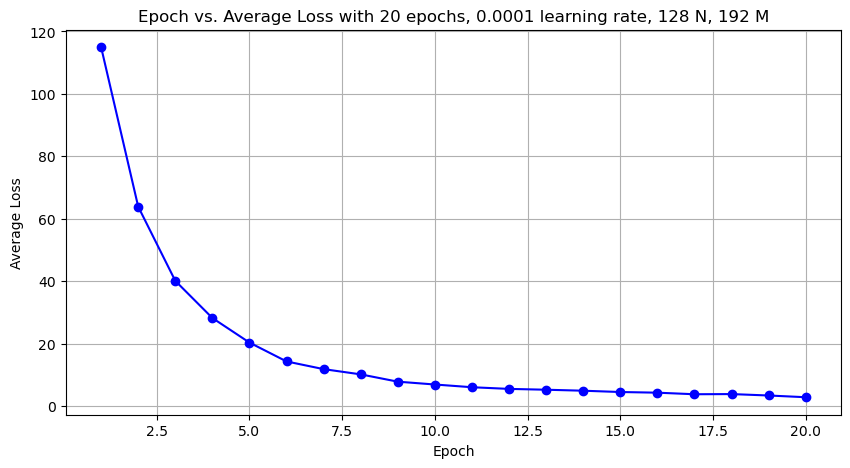

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 102.509 |	MSE loss: 0.402 |	PSNR: 3.961 |	SSIM: 0.007

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 55.287 |	MSE loss: 0.217 |	PSNR: 6.640 |	SSIM: 0.017

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 35.985 |	MSE loss: 0.141 |	PSNR: 8.505 |	SSIM: 0.034

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 22.665 |	MSE loss: 0.089 |	PSNR: 10.513 |	SSIM: 0.048

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 15.996 |	MSE loss: 0.063 |	PSNR: 12.026 |	SSIM: 0.069

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 12.453 |	MSE loss: 0.049 |	PSNR: 13.113 |	SSIM: 0.074

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 9.931 |	MSE loss: 0.0

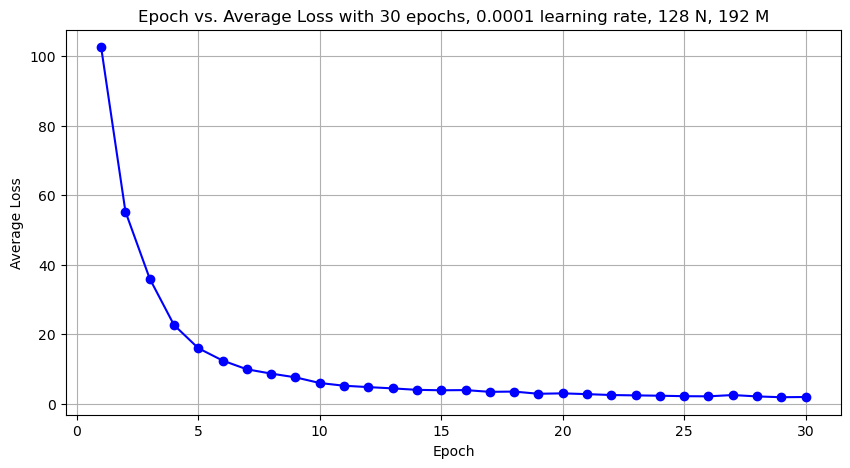

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 481.829 |	MSE loss: 1.890 |	PSNR: -2.760 |	SSIM: 0.000

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 236.979 |	MSE loss: 0.929 |	PSNR: 0.324 |	SSIM: 0.002

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 152.781 |	MSE loss: 0.599 |	PSNR: 2.229 |	SSIM: 0.004

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 109.659 |	MSE loss: 0.430 |	PSNR: 3.668 |	SSIM: 0.008

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 85.407 |	MSE loss: 0.335 |	PSNR: 4.751 |	SSIM: 0.013

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 71.156 |	MSE loss: 0.279 |	PSNR: 5.543 |	SSIM: 0.017

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 60.813 |	MSE loss: 0.238 |	

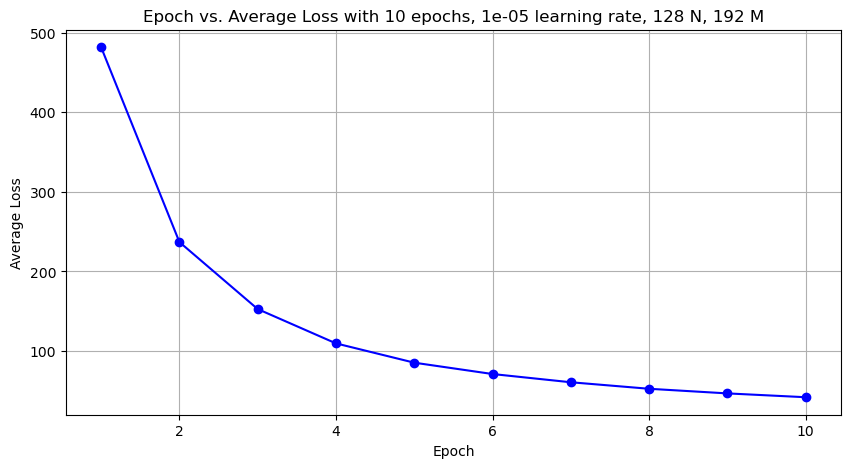

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 570.316 |	MSE loss: 2.237 |	PSNR: -3.488 |	SSIM: 0.000

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 276.362 |	MSE loss: 1.084 |	PSNR: -0.342 |	SSIM: 0.001

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 175.780 |	MSE loss: 0.689 |	PSNR: 1.622 |	SSIM: 0.003

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 119.443 |	MSE loss: 0.468 |	PSNR: 3.297 |	SSIM: 0.006

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 89.212 |	MSE loss: 0.350 |	PSNR: 4.563 |	SSIM: 0.011

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 72.466 |	MSE loss: 0.284 |	PSNR: 5.465 |	SSIM: 0.015

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 61.290 |	MSE loss: 0.240 |

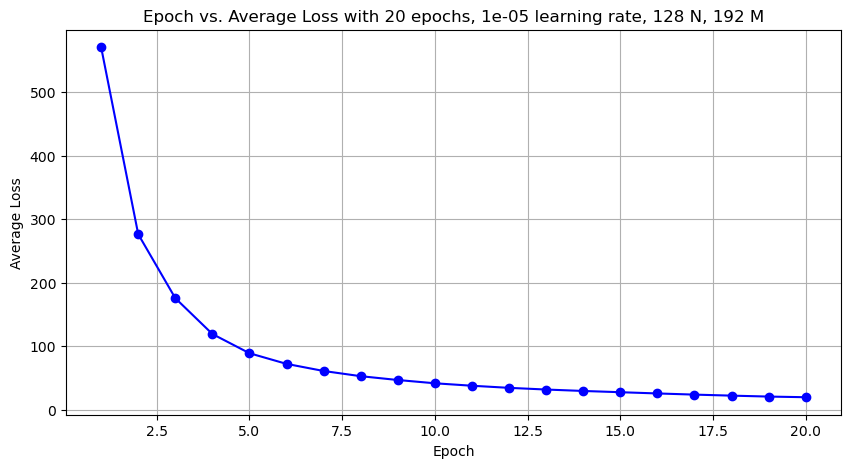

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 0: Average losses:	Loss: 412.259 |	MSE loss: 1.617 |	PSNR: -2.081 |	SSIM: 0.000

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 1: Average losses:	Loss: 233.410 |	MSE loss: 0.915 |	PSNR: 0.388 |	SSIM: 0.001

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 2: Average losses:	Loss: 156.740 |	MSE loss: 0.615 |	PSNR: 2.117 |	SSIM: 0.004

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 3: Average losses:	Loss: 110.716 |	MSE loss: 0.434 |	PSNR: 3.625 |	SSIM: 0.007

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 4: Average losses:	Loss: 85.825 |	MSE loss: 0.337 |	PSNR: 4.730 |	SSIM: 0.012

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 5: Average losses:	Loss: 69.768 |	MSE loss: 0.274 |	PSNR: 5.629 |	SSIM: 0.017

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 6: Average losses:	Loss: 59.254 |	MSE loss: 0.232 |	

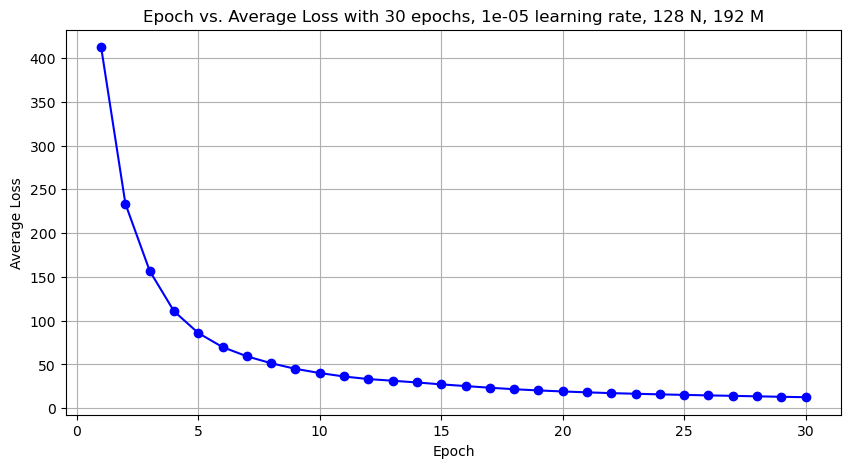

In [25]:
lr = [1e-3, 1e-4, 1e-5]
epochs = [10, 20, 30]
nm = [[32,48], [64,96], [128,192]]

class new_net(Network):
    def __init__(self, N, M, lr, epoch, init_weights=True, **kwargs):
        super().__init__(N, M, **kwargs)
        self.lr = lr
        self.epoch = epoch
        self.N, self.M = N, M
        self.loss_epoch = []

    def __str__(self) -> str:
        return f'N: {self.N}, M: {self.M}, lr: {self.lr}, epoch: {self.epoch}' + super().__str__()
    
    def update_loss(self, loss):
        self.loss_epoch.append(loss)

def new_test_epoch(epoch, test_dataloader, model, criterion,last_epoch):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    ssim_avg = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            psnr.update(PSNR(d_out, d))
            ssim_avg.update(ssim(d * 255, d_out * 255, data_range=255, size_average=True))

    if 1:
        print(
            f"Model with {model.epoch} epochs, {model.lr} learning rate, {model.N} N, {model.M} M Test epoch {epoch}: Average losses:"
            f"\tLoss: {loss.avg:.3f} |"
            f"\tMSE loss: {mse_loss.avg:.3f} |"
            f"\tPSNR: {psnr.avg:.3f} |"
            f"\tSSIM: {ssim_avg.avg:.3f}\n"
        )
    return loss.avg

def train_one_epoch_withoutprint(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

def new_plotloss(newnet):

    xs = range(1, newnet.epoch + 1)

    ys = newnet.loss_epoch
    y = []
    for i in ys:
        y.append(i.cpu().detach().numpy())


    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(xs, y, marker='o', linestyle='-', color='b')
    plt.title(f'Epoch vs. Average Loss with {newnet.epoch} epochs, {newnet.lr} learning rate, {newnet.N} N, {newnet.M} M')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()


nets = []
i = 0
while i < 3:
    j = 0
    while j < 3:
        k = 0
        while k < 3:
            net = new_net(nm[i][0], nm[i][1], lr[j], epochs[k])
            nets.append(net.to(device))
            k += 1
        j += 1
    i += 1


for net in nets:
    optimizer = configure_optimizers(net, net.lr)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
#     print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    for epoch in range(0, net.epoch):
        train_one_epoch_withoutprint(
            net,
            criterion,
            train_dataloader,
            optimizer,
            epoch,
            clip_max_norm,
        )
        loss = new_test_epoch(epoch, test_dataloader, net, criterion,epoch==net.epoch-1)
        net.loss_epoch.append(loss)
        lr_scheduler.step(loss)

        is_best = loss < best_loss
        best_loss = min(loss, best_loss)
    new_plotloss(net)



    
